<h1 style="text-align: center">Twitter Sentiment Analysis</h1>

![](assets/sentiment.png)

<br/> 
## Twitter datas are too unsructured for machine learning.
<br/> 
### We have to prepare them to achieve better accuracy at prediction
<br/> 

In [31]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

###### The dataset is not in "UTF-8" encoding

In [32]:
train = pd.read_csv("dataset/train.csv", encoding="ISO-8859-1")
test = pd.read_csv("dataset/test.csv", encoding="ISO-8859-1")
with open('assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

###### Setting Pandas DataFrame to show non-truncated table

In [33]:
pd.set_option('display.max_colwidth', -1)

In [34]:
train.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T


###### Merging test and train data to preprocess them together

In [35]:
# total_data = train.append(test, ignore_index=True)
total_data = train

In [36]:
train.info()
tweet = train.columns.values[2]
sentiment = train.columns.values[1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
ItemID           99989 non-null int64
Sentiment        99989 non-null int64
SentimentText    99989 non-null object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [37]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299989 entries, 0 to 299988
Data columns (total 2 columns):
ItemID           299989 non-null int64
SentimentText    299989 non-null object
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [38]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
ItemID           99989 non-null int64
Sentiment        99989 non-null int64
SentimentText    99989 non-null object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [39]:
total_data[-5:]

,ItemID,Sentiment,SentimentText
99984,99996,0,@Cupcake seems like a repeating problem hope you're able to find something.
99985,99997,1,"@cupcake__ arrrr we both replied to each other over different tweets at the same time , i'll see you then, Duno where the hell Kateyy is!"
99986,99998,0,@CuPcAkE_2120 ya i thought so
99987,99999,1,@Cupcake_Dollie Yes. Yes. I'm glad you had more fun with me.
99988,100000,1,@cupcake_kayla haha yes you do


<br/>

# 1)  Preprocessing

* **Convert every tweets to lower case**
* **Remove Twitter username**
* **Remove punctuations, numbers and special characters**
* **Convert more than 2 letter repetitions to 2 letter ( example (funnnnny --> funny))**
* **Remove extra spaces**
* **Remove URLs**
* **Emoji analysis**
* **Handle contractions words**
    - **" can't " >> " can not "**
    - **" won't " >> " will not "**
    - **" should't " >> " should not "**
* **Remove [Stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)**
* **Tokenization**
* **Stemming**

`check this to see `**[Live twitter emoji usage](https://emojitracker.com/)**` (the webpage is heroku backed, so it is safe)`

`check this `**[Stackexchange answer](https://datascience.stackexchange.com/questions/15765/nlp-why-is-not-a-stop-word)**` to know why we have to modify stop words`

`check this `**[Stop words for sentiment analysis research paper](http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf)**` to know why we need specific stop words`

`Check this `**[Stackoverflow answer](https://stackoverflow.com/a/52674448/8141330)**` to know how to loop faster in python`

`Check this `**[Stackoverflow answer](https://stackoverflow.com/a/43023503/8141330)**` to know how contraction dictionary of shortened words can be done`

`Problem: This is dataset specific. As this is not in unicode, every (') is replaced with (&quot;) . Click this ` **[Stackoverflow anwser](https://stackoverflow.com/questions/24602154/explain-what-quot-means)** ` to see in details.`

##### Define a function which handles emoji classifications

In [62]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet


###### Define a function which will preprocess the tweets

In [63]:
import re
def process_tweet(tweet):
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   # Replaces contractions
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space
    tweet = tweet.lower()                                             # Lowercases the string
    return tweet

###### Now make a new column for side by side comparison of new tweets vs old tweets

In [64]:
total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data[tweet])

###### Let's compare unprocessed tweets with the processed one

In [65]:
total_data

,ItemID,Sentiment,SentimentText,processed_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer
2,3,1,omg its already 7:30 :O,omg its already positiveemoji
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry have been at this dentist since was suposed just get crown put on mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t
5,6,0,or i just worry too much?,or just worry too much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number


### This is an implementation of stop words and tokenization we will use it later

In [43]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gunjan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gunjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2) Most used words

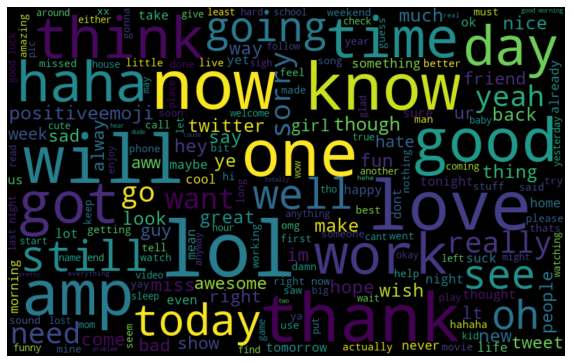

In [66]:
all_words = ' '.join([text for text in total_data['processed_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## 2.2) Most used positive words

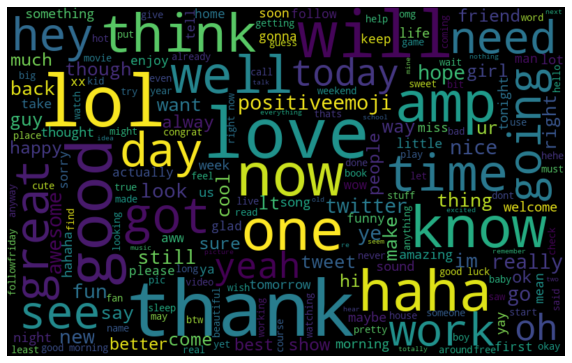

In [67]:
positive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## 2.3) Most used negetive words

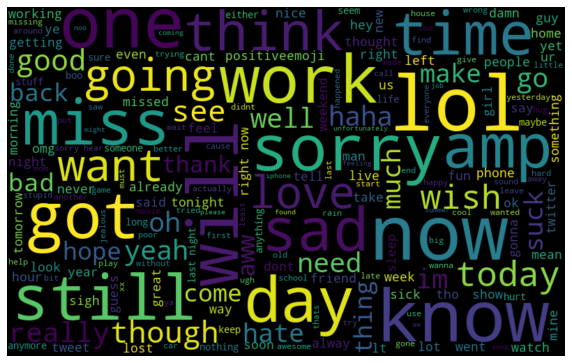

In [70]:
negetive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negetive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# See the word `lol`. It is used both in positive and negetive(sarcastic) sentiments. We still can't classify sarcasm.